In [1]:
%load_ext autoreload
%autoreload 2

# Validation Notebook

In [2]:
import xarray as xr
import xskillscore as xs
import hydra
import numpy as np
import os
import datetime
from IPython.display import display
from matplotlib import pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
with hydra.initialize_config_module('crims2s.conf'):
    mldataset_cfg = hydra.compose('mldataset')

In [5]:
xr.set_options(keep_attrs=True)
#xr.set_options(display_style='text')

In [6]:
SHOW_VISUALISATIONS: bool = False

EXPORT_DATA: bool = False
    
COMPUTE_EACH_TROPICS: bool = False

In [7]:
OUTPUT = '***BASEDIR***'
OUTPUT = "***BASEDIR***/last-validation-files-from-organizers"
EDGES_FILE = ''

EXPORT_PATH = '***HOME***Projets/S2S-Competition/outputs'
CMAP = "coolwarm"

CMAP = "RdYlGn"

# Validation class

In [8]:
def create_climatology() -> xr.DataArray:
    clim_p = xr.DataArray([1/3, 1/3, 1/3], dims='category', coords={'category':['below normal', 'near normal', 'above normal']}).to_dataset(name='tp')
    clim_p['t2m'] = clim_p['tp']

    return clim_p

In [9]:
import os
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs


class Validation():
    def __init__(self, obs: xr.Dataset, preds: xr.Dataset, edges: xr.Dataset, use_dry_mask=False) -> None:
        
       
        self.obs: xr.Dataset = obs
        self.preds: xr.Dataset = preds
            
        self.rps_ml: xr.Dataset = xr.Dataset()
        self.rps_clim: xr.Dataset = xr.Dataset()
            
        self.regions_positions: dict = {'North_America': (slice(0, 50), slice(120, 300)),
                                        'South_America': (slice(40, 100), slice(150, 300)),
                                        'Europe_Africa_Asia': (slice(0, 100), slice(0, 60)),
                                        'Oceania': (slice(50, 100), slice(70, 120))}
            
        self.regions_positions_orthographic: dict = {'North_America': (-80, 25),
                                                     'South_America': (-60, -15),
                                                     'Europe_Africa_Asia': (50, 25),
                                                     'Oceania': (120, 1)}
            
        self.__assert_predictions_2020(self.obs)
        self.__assert_predictions_2020(self.preds)
        
        self.use_dry_mask = use_dry_mask
        print("Validation class successfully initialised")
        
      
        
    def __assert_predictions_2020(self, preds_test) -> None:
        """
        REFORMAT FROM ORGANIZERS NOTEBOOKS
        Check the variables, coordinates and dimensions of 2020 predictions.
        """
        
        # is dataset
        assert isinstance(preds_test, xr.Dataset)

        # has both vars: tp and t2m
        assert 'tp' in preds_test.data_vars
        assert 't2m' in preds_test.data_vars

        ## coords
        # forecast_time
        d = pd.date_range(start='2020-01-02', freq='7D', periods=53)
        forecast_time = xr.DataArray(d, dims='forecast_time', coords={'forecast_time':d})
        assert (forecast_time == preds_test['forecast_time']).all()

        # longitude
        lon = np.arange(0., 360., 1.5)
        longitude = xr.DataArray(lon, dims='longitude', coords={'longitude': lon})
        assert (longitude == preds_test['longitude']).all()

        # latitude
        lat = np.arange(90., -90.1, 1.5)
        latitude = xr.DataArray(lat, dims='latitude', coords={'latitude': lat})
        assert (latitude == preds_test['latitude']).all()
        
        # LATITUDE DEFINITION ACCORDING TO SCORING SCRIPT
        #assert (preds_test.latitude.diff('latitude')==-1.5).all()
        #assert 60 in preds_test.latitude
        #assert -60 in preds_test.latitude

        # lead_time
        lead = [pd.Timedelta(f'{i} d') for i in [14, 28]]
        lead_time = xr.DataArray(lead, dims='lead_time', coords={'lead_time': lead})
        assert (lead_time == preds_test['lead_time']).all()

        # category
        cat = np.array(['below normal', 'near normal', 'above normal'], dtype='<U12')
        category = xr.DataArray(cat, dims='category', coords={'category': cat})
        assert (category == preds_test['category']).all()

        # size
        #from dask.utils import format_bytes
        #size_in_MB = float(format_bytes(preds_test.nbytes).split(' ')[0])
        #assert size_in_MB > 50
        #assert size_in_MB < 250

        # no other dims
        assert set(preds_test.dims) - {'category', 'forecast_time', 'latitude', 'lead_time', 'longitude'} == set()
        
        
    def compute_RPS(self, preds, obs, dim=['forecast_time']):          
        climatology = create_climatology()
        
        rps_clim_t2m = xs.rps(obs.t2m, climatology.t2m, category_edges=None, dim=dim, input_distributions='p').compute()  
        if self.use_dry_mask:
            rps_clim_tp = self.__compute_rps_with_dry_mask(obs.tp, climatology.tp)
        else:
            rps_clim_tp = xs.rps(obs.tp, climatology.tp, category_edges=None, dim=dim, input_distributions='p').compute()
        rps_clim = xr.merge([rps_clim_t2m, rps_clim_tp])
        
        rps_ml_t2m = xs.rps(obs.t2m, preds.t2m, category_edges=None, dim=dim, input_distributions='p').compute()  
        if self.use_dry_mask:
            rps_ml_tp = self.__compute_rps_with_dry_mask(obs.tp, preds.tp)
        else:
            rps_ml_tp = xs.rps(obs.tp, preds.tp, category_edges=None, dim=dim, input_distributions='p').compute()
        
        rps_ml = xr.merge([rps_ml_t2m, rps_ml_tp])

        return rps_ml, rps_clim
    
    def __compute_rps_with_dry_mask(self, reference, model):
        dry_mask = (edges.isel(category_edge = 1) < 1.0).tp
        
        reference_where_wet = reference.where(~dry_mask.sel(forecast_time=reference.forecast_time), other=np.nan).drop('category_edge')        
        model_where_wet = model.where(~dry_mask.sel(forecast_time=reference.forecast_time), other=np.nan).drop('category_edge')
        
        return xs.rps(reference_where_wet, model_where_wet, category_edges=None, dim=['forecast_time'], input_distributions='p').compute()
            
    def plot_rps(self) -> None:
        
        rps_ml, rps_clim = self.compute_RPS(self.preds, self.obs)
        
        for v in rps_ml.data_vars:
            data_var = rps_clim[v]
            data_var.where(data_var.latitude > -60., drop=True).plot(robust=True, col='lead_time', figsize=(10,5))

        for v in self.rps_clim.data_vars:
            data_var = rps_clim[v]
            data_var.where(data_var.latitude > -60., drop=True).plot(robust=True, col='lead_time', figsize=(10,5))
        
    def __compute_tropic_mask(self, rpss: xr.Dataset) -> xr.Dataset:
        
        mask = xr.ones_like(rpss.isel(lead_time=0, drop=True)).reset_coords(drop=True).t2m
        boundary_tropics = 30
        mask = xr.concat([mask.where(mask.latitude > boundary_tropics),
                          mask.where(np.abs(mask.latitude) <= boundary_tropics),
                          mask.where((mask.latitude < -boundary_tropics) & (mask.latitude > -60))], 'area')
        mask = mask.assign_coords(area=['northern_extratropics', 'tropics', 'southern_extratropics'])
        mask.name = 'area'

        return mask.where(rpss.t2m.isel(lead_time=0, drop=True).notnull())
    
    def __compute_each_tropic_mask(self, rpss: xr.Dataset) -> xr.Dataset:
        
        mask = xr.ones_like(rpss.isel(lead_time=0, drop=True)).reset_coords(drop=True).t2m

        it = [i for i in range(int(self.preds.latitude.data.min()), int(self.preds.latitude.data.max()) + 1, 10)]
        mask_tropics = list()
        tropic_name = list()
        for i in range(len(it)):      
            if i + 1 < len(it):
                up = it[i+1]
            else:
                break

            tropic_name.append(str(it[i]) + " - " + str(up))
            mask_tropics.append(mask.where((mask.latitude >= it[i]) & (mask.latitude < up)))

        mask = xr.concat(mask_tropics, 'area')
        mask = mask.assign_coords(area=tropic_name)
        mask.name = 'area'
        
        return mask.where(rpss.t2m.isel(lead_time=0, drop=True).notnull())
    
    def __compute_rpss_organizers(self, rps_ml, rps_clim) -> xr.Dataset:
        return (1 - rps_ml / rps_clim)
    
    def compute_scores_from_scoring_image(self):
        
        """
        Compute scores from scoring image provide by organizers
        CARREFUL : when assert prediction, latitude are not define as Renku repository !!!
        """

        rps_ML, rps_clim = self.compute_RPS(self.preds, self.obs, dim=[])
        
        
        self.rpl_ML = rps_ML
        self.rps_clim = rps_clim

        # submission rpss wrt climatology
        rpss = (1 - rps_ML / rps_clim)
        

        # https://renkulab.io/gitlab/aaron.spring/s2s-ai-challenge-template/-/issues/7
        # penalize
        penalize = self.obs.where(self.preds!=1, other=-10).mean('category')
        
        print(penalize)
        
        rpss = rpss.where(penalize!=0,other=-10)

        # clip
        rpss = rpss.clip(-10, 1)

        # average over all forecasts
        rpss = rpss.mean('forecast_time')
        
        

        # weighted area mean
        weights = np.cos(np.deg2rad(np.abs(rpss.latitude)))
        # spatially weighted score averaged over lead_times and variables to one single value
        scores = rpss.sel(latitude=slice(None, -60)).weighted(weights).mean('latitude').mean('longitude')
        
        print(scores.to_array().mean('lead_time'))
        
        scores = scores.to_array().mean(['lead_time', 'variable']).reset_coords(drop=True)
        # score transfered to leaderboard
        return scores.item()
          
    def compute_scores_from_organizers_RPSS(self, compute_each_tropics=False) -> pd.DataFrame:
        """
        REFORMAT FROM ORGANIZERS NOTEBOOKS
        Compute RPSS according to notebook organizers
        """
        
        rps_ml, rps_clim = self.compute_RPS(self.preds, self.obs)
        
        rpss_organizers = self.__compute_rpss_organizers(rps_ml, rps_clim)
        
        mask = (self.__compute_each_tropic_mask(rps_ml) if compute_each_tropics else self.__compute_tropic_mask(rps_ml))
        weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
        
        scores = (rpss_organizers*mask).weighted(weights).mean('latitude').mean('longitude')
        
        return scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)
        
    def compute_scores_from_arlan_RPSS(self, compute_each_tropics=False) -> pd.DataFrame:
        """
        Compute RPSS according to Arlan's definition
        """
        
        rps_ml, rps_clim = self.compute_RPS(self.preds, self.obs)
        
        mask = (self.__compute_each_tropic_mask(rps_ml) if compute_each_tropics else self.__compute_tropic_mask(rps_ml))
        weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
        
        latitude_longitude_mean_ML = (rps_ml*mask).weighted(weights).mean(dim=['latitude', 'longitude'])
        latitude_longitude_mean_clim = (rps_clim*mask).weighted(weights).mean(dim=['latitude', 'longitude'])
        
        rpss_arlan = 1 - latitude_longitude_mean_ML/latitude_longitude_mean_clim
                
        return rpss_arlan.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)
    
    def __extract_from_month(self, xr_data: xr.Dataset, month: int) -> xr.Dataset:
        mask = xr_data.forecast_time.dt.month == month        
        return xr_data.sel(forecast_time=mask)
    
    def compute_monthly_scores(self, compute_each_tropics:bool = False) -> pd.DataFrame:
        
        scores_dict: dict = dict()
        date_list:list = list()
        for month in range(1, 13):                       
            #date = (str("2020-0") + str(month+1) if month + 1 <= 9 else str("2020-") + str(month+1))
            
            obs = self.__extract_from_month(xr_data = self.obs, month=month)
            preds = self.__extract_from_month(xr_data = self.preds, month=month)          
            rps_ml, rps_clim = self.compute_RPS(preds, obs)          
            rpss_organizers = self.__compute_rpss_organizers(rps_ml, rps_clim)
            
            mask = (self.__compute_each_tropic_mask(rps_ml) if compute_each_tropics else self.__compute_tropic_mask(rps_ml))
            weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
            
            scores = ((rpss_organizers*mask).weighted(weights).mean('latitude').mean('longitude') if compute_each_tropics else rpss_organizers.weighted(weights).mean('latitude').mean('longitude')) 
                
            scores_dict[month] = scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)
            date_list.append(month)
         
        scores = pd.concat(list(scores_dict.values()), axis=1)
        
        if compute_each_tropics:
            index = [(month, (timed[0], timed[1])) for month, timed in zip(date_list, [(scores.columns[0], scores.columns[1]) for i in range(24)])]
            
            new_index = list()
            for item in index:
                new_index.append((item[0], item[1][0]))
                new_index.append((item[0], item[1][1]))

            scores.columns = pd.MultiIndex.from_tuples(new_index)
        else:
            scores.columns = date_list
            
        return scores
    
    def compute_trimestrial_scores(self):
        
        first_trimestrial = ("2020-01", "2020-04")
        second_trimestrial= ("2020-05", "2020-08")
        third_trimestrial = ("2020-09", "2020-12")
        
        
              
        scores_list: list = list()
        for trimestrial in range(1, 13, 4):
            position = ((self.preds.forecast_time.dt.month >= trimestrial) & 
                        (self.preds.forecast_time.dt.month < trimestrial + 4))
                        
            obs = self.obs.isel(forecast_time=position)
            preds = self.preds.isel(forecast_time=position)
            rps_ml, rps_clim = self.compute_RPS(preds, obs)
            rpss_organizers = self.__compute_rpss_organizers(rps_ml, rps_clim)
            mask = self.__compute_tropic_mask(rps_ml)      
            weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
            scores = rpss_organizers.weighted(weights).mean('latitude').mean('longitude')
            scores_list.append(scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2))
            
        scores_list = pd.concat(scores_list, axis=1)
        scores_list.columns = ["January to April", "May to August", "September to December"]
        return scores_list
    
    
    def plot_by_region(self, what:str='observations', feat:str='t2m', region:str='North_America', category:int=2, forecast_time:int=0, orthographic: bool=False):
        
        assert 't2m' or 'tp' in feat
        assert region in list(val.regions_positions.keys())
        assert category <= 2
        
        print('Plot', feat,'for category n°', category, 'for', what, 'data for', region, 'for forecast_time', forecast_time)
        
        latitude: slice = self.regions_positions[region][0]
        longitude: slice = self.regions_positions[region][1]
            
        orthographic_pos = self.regions_positions_orthographic[region]
                    
        if what == 'observations':
            if not orthographic:
                self.obs[feat].isel(category=category, 
                                    forecast_time=forecast_time, 
                                    latitude=latitude, 
                                    longitude=longitude).plot(col='lead_time', figsize=(10,5))
            else:
                self.obs[feat].isel(category=category, 
                                    forecast_time=forecast_time).plot(col='lead_time', subplot_kws=dict(projection=ccrs.Orthographic(orthographic_pos[0], orthographic_pos[1]), facecolor="gray"),
                                                                     transform=ccrs.PlateCarree(), 
                                                                     figsize=(20,20))
        elif what == 'predictions':
            if not orthographic:
                self.preds[feat].isel(category=category, 
                                      forecast_time=forecast_time, 
                                      latitude=latitude, 
                                      longitude=longitude).plot(col='lead_time', figsize=(10,5))
            else:
                self.preds[feat].isel(category=category, 
                                    forecast_time=forecast_time).plot(col='lead_time', subplot_kws=dict(projection=ccrs.Orthographic(orthographic_pos[0], orthographic_pos[1]), facecolor="gray"),
                                                                      transform=ccrs.PlateCarree(),
                                                                      figsize=(20,20))
        else:
            print(what, 'is not in possible visualisation. Try observations or predictions')

## Open and preprocess Dataset

In [34]:
#obs = xr.open_dataset("***BASEDIR***/renku/hindcast-like-observations_2018-2019_biweekly_terciled.nc")
#preds = xr.open_dataset("***BASEDIR***/ml-output/2021-08-25-emos-normal-gamma-no-multiplex-without-validtime-weeks36.nc")

In [11]:
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-14/15-29-32/emos_cube.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [12]:
preds = xr.open_dataset("***BASEDIR***/runs/dataset/infer/outputs/2021-09-14/16-15-40/bayes_nocube.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [13]:
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-07/14-28-19/normal_normal_monthly.nc").drop('valid_time')
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [14]:
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-16/16-01-21/bayes_conv_512.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [ ]:
# Simple debiasing, monthly. 
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-23/20-03-29/debias.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [221]:
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-23/11-27-10/global_branch.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [ ]:
# EMOS using ECCC data.
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-23/19-55-16/emos_eccc.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [ ]:
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-23/22-34-19/bayes_conv_eccc.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [162]:

preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-27/11-47-01/bayes_eccc_ncep.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [186]:

preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-28/18-15-38/emos_mix.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [31]:
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-29/14-29-54/bayes_lienar_all.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [45]:
preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-10-01/11-13-45/bayes_multi_checkpoint.nc")
obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [68]:
#preds = xr.open_dataset("***BASEDIR***/runs/infer/outputs/2021-09-13/10-22-18/bayes_linear.nc")
#obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")

In [69]:
# original 2020 observations : "***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc"
# original 2020 ML Model : "***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc"

# obs = xr.open_dataset("***BASEDIR***/last-validation-files-from-organizers/forecast-like-observations_2020_biweekly_terciled.nc")
# preds = xr.open_dataset("***BASEDIR***/ml-output/2021-08-25-emos-normal-gamma-no-multiplex-without-validtime-weeks36.nc")

In [46]:
edges = xr.open_dataset(mldataset_cfg.set.aggregated_obs.edges)
edges = edges.rename(week='forecast_time').assign_coords(forecast_time=preds.forecast_time)

In [47]:
val = Validation(obs=obs, preds=preds, edges=edges, use_dry_mask = False)

Validation class successfully initialised


In [48]:
rps_ML, rps_clim = val.compute_RPS(val.preds, val.obs, dim=[])

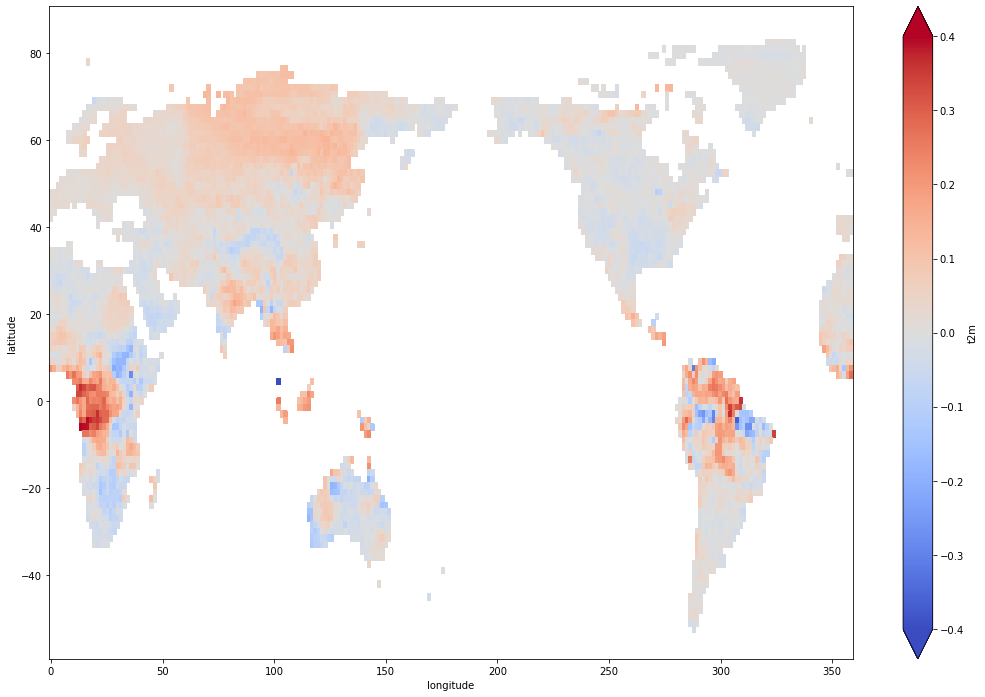

In [49]:
(1.0 - rps_ML / rps_clim).where(rps_ML.latitude > -60, drop=True).mean(dim=['lead_time', 'forecast_time']).t2m.plot(size=12, cmap='coolwarm', vmin=-0.4, vmax=0.4)

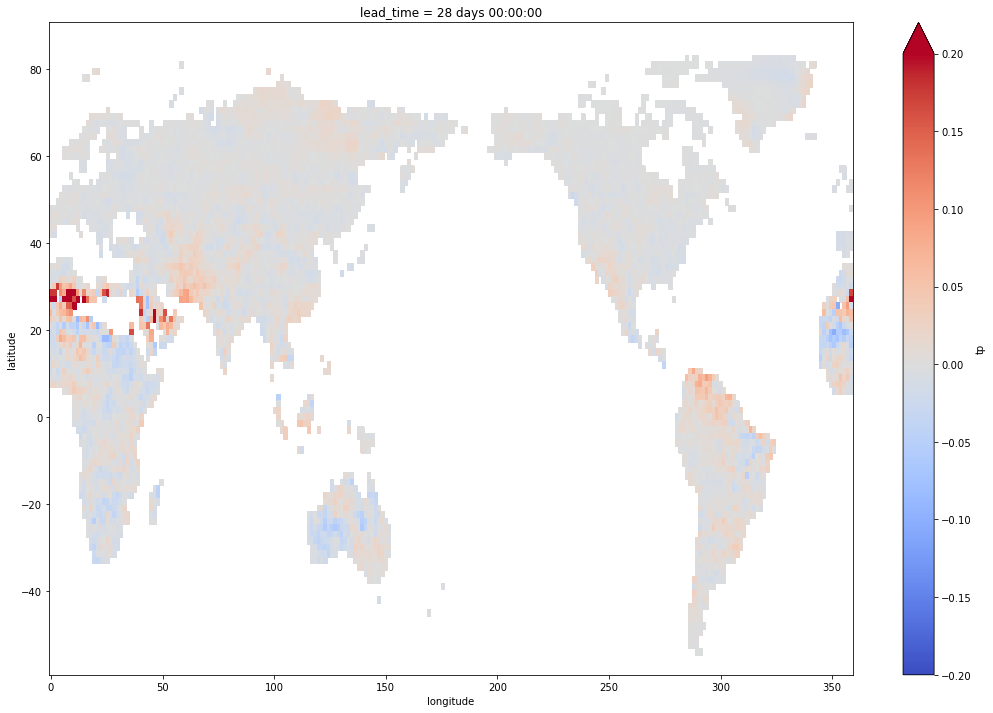

In [25]:
(1.0 - rps_ML / rps_clim).where(rps_ML.latitude > -60, drop=True).mean(dim=['forecast_time']).isel(lead_time=1).tp.plot(size=12, cmap='coolwarm', vmin=-0.2, vmax=0.2)

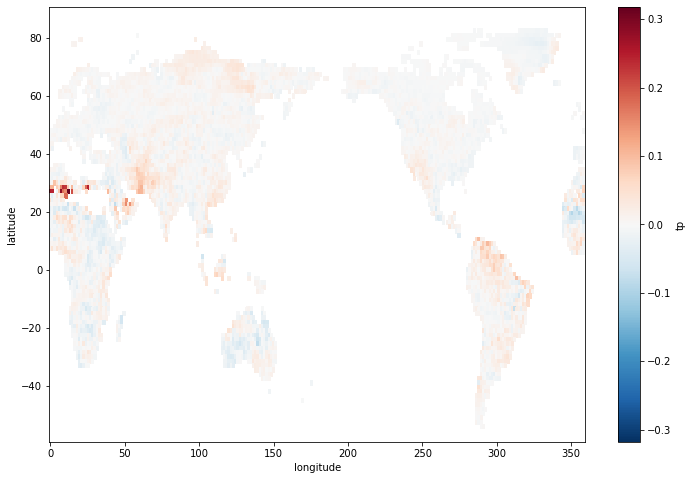

In [75]:
(1.0 - rps_ML / rps_clim).where(rps_ML.latitude > -60, drop=True).mean(dim=['lead_time', 'forecast_time']).tp.plot(size=8)

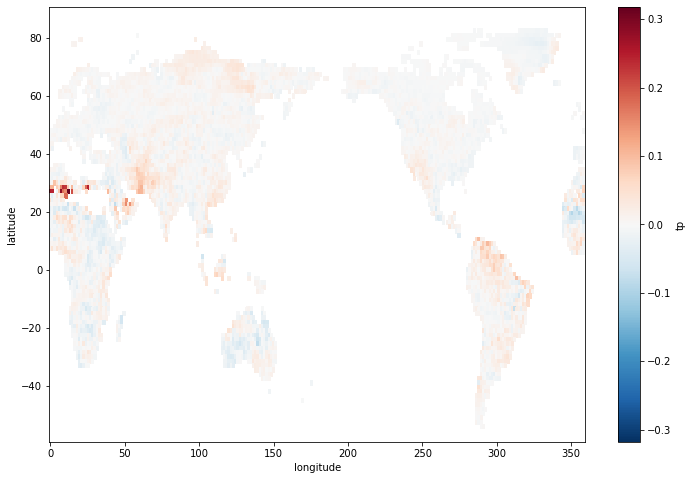

In [76]:
(1.0 - rps_ML / rps_clim).where(rps_ML.latitude > -60, drop=True).mean(dim=['lead_time', 'forecast_time']).tp.plot(size=8)

## Compute scores for organizers scoring image

Plot t2m for category n° 2 for predictions data for North_America for forecast_time 0


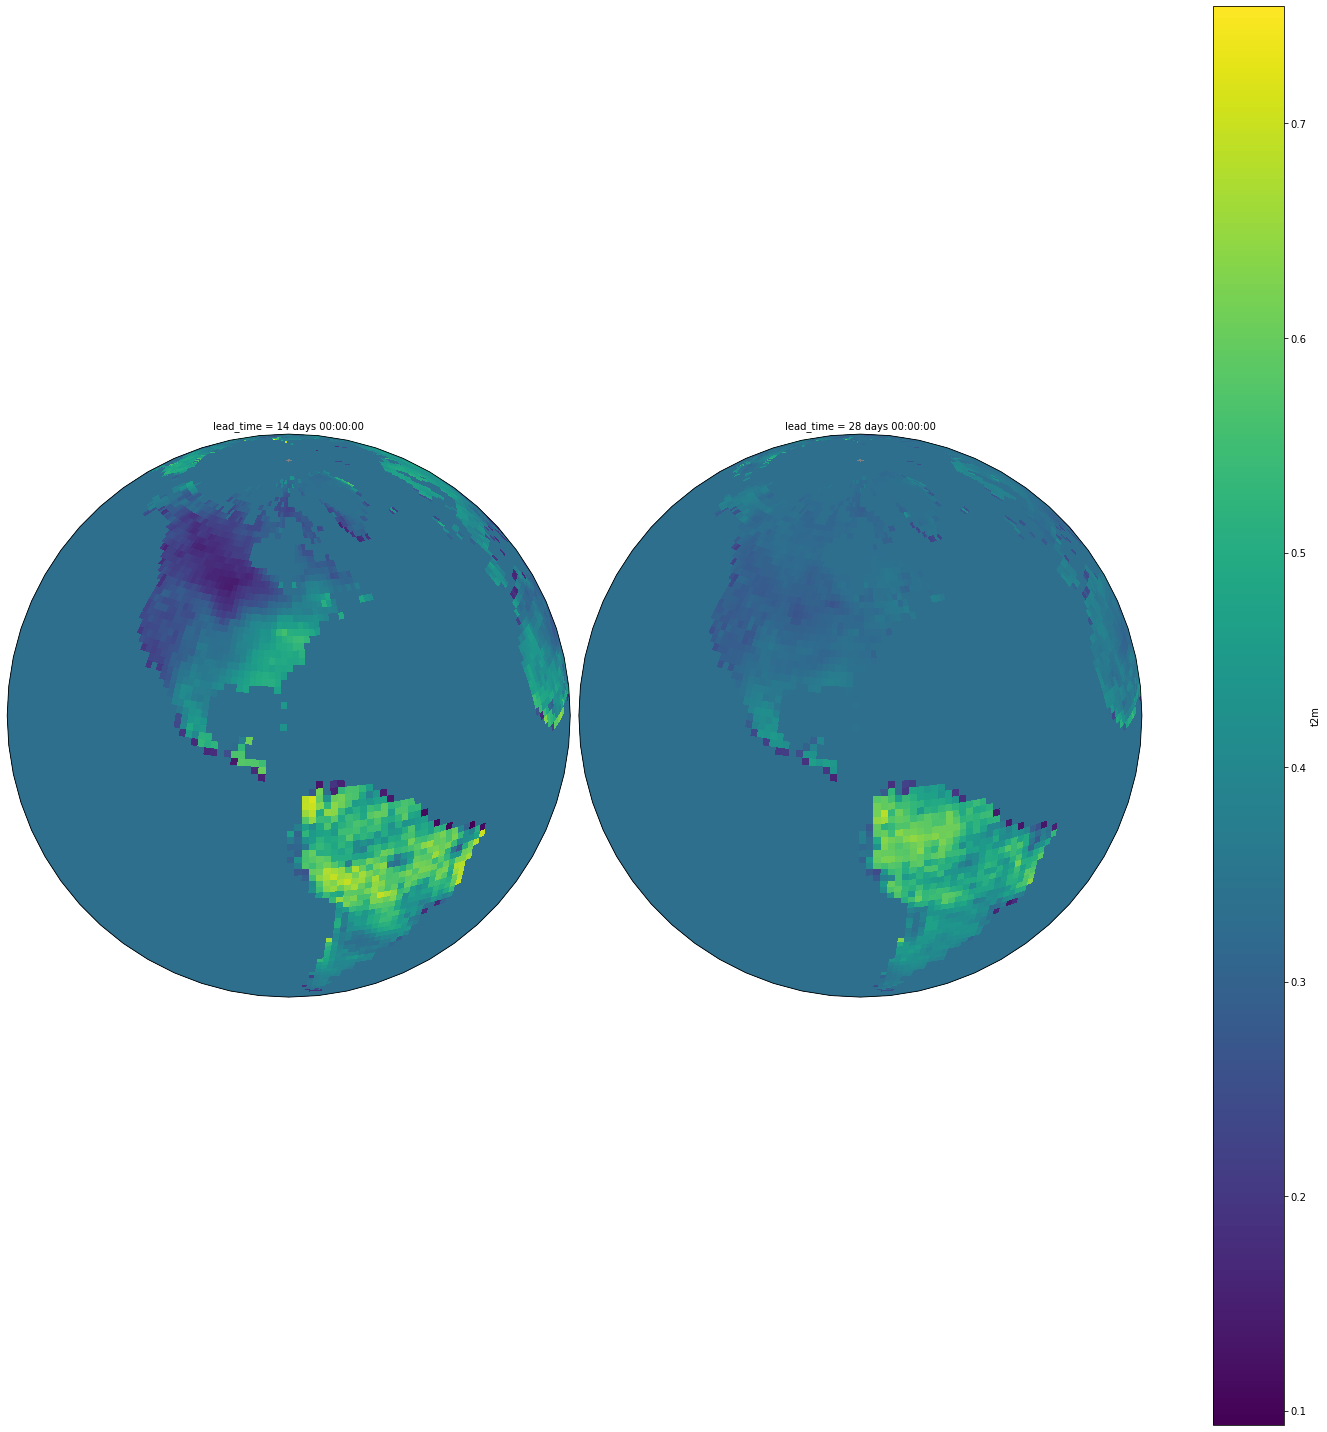

In [26]:
val.plot_by_region(what='predictions', region='North_America', orthographic=True)

Plot t2m for category n° 2 for predictions data for Europe_Africa_Asia for forecast_time 0


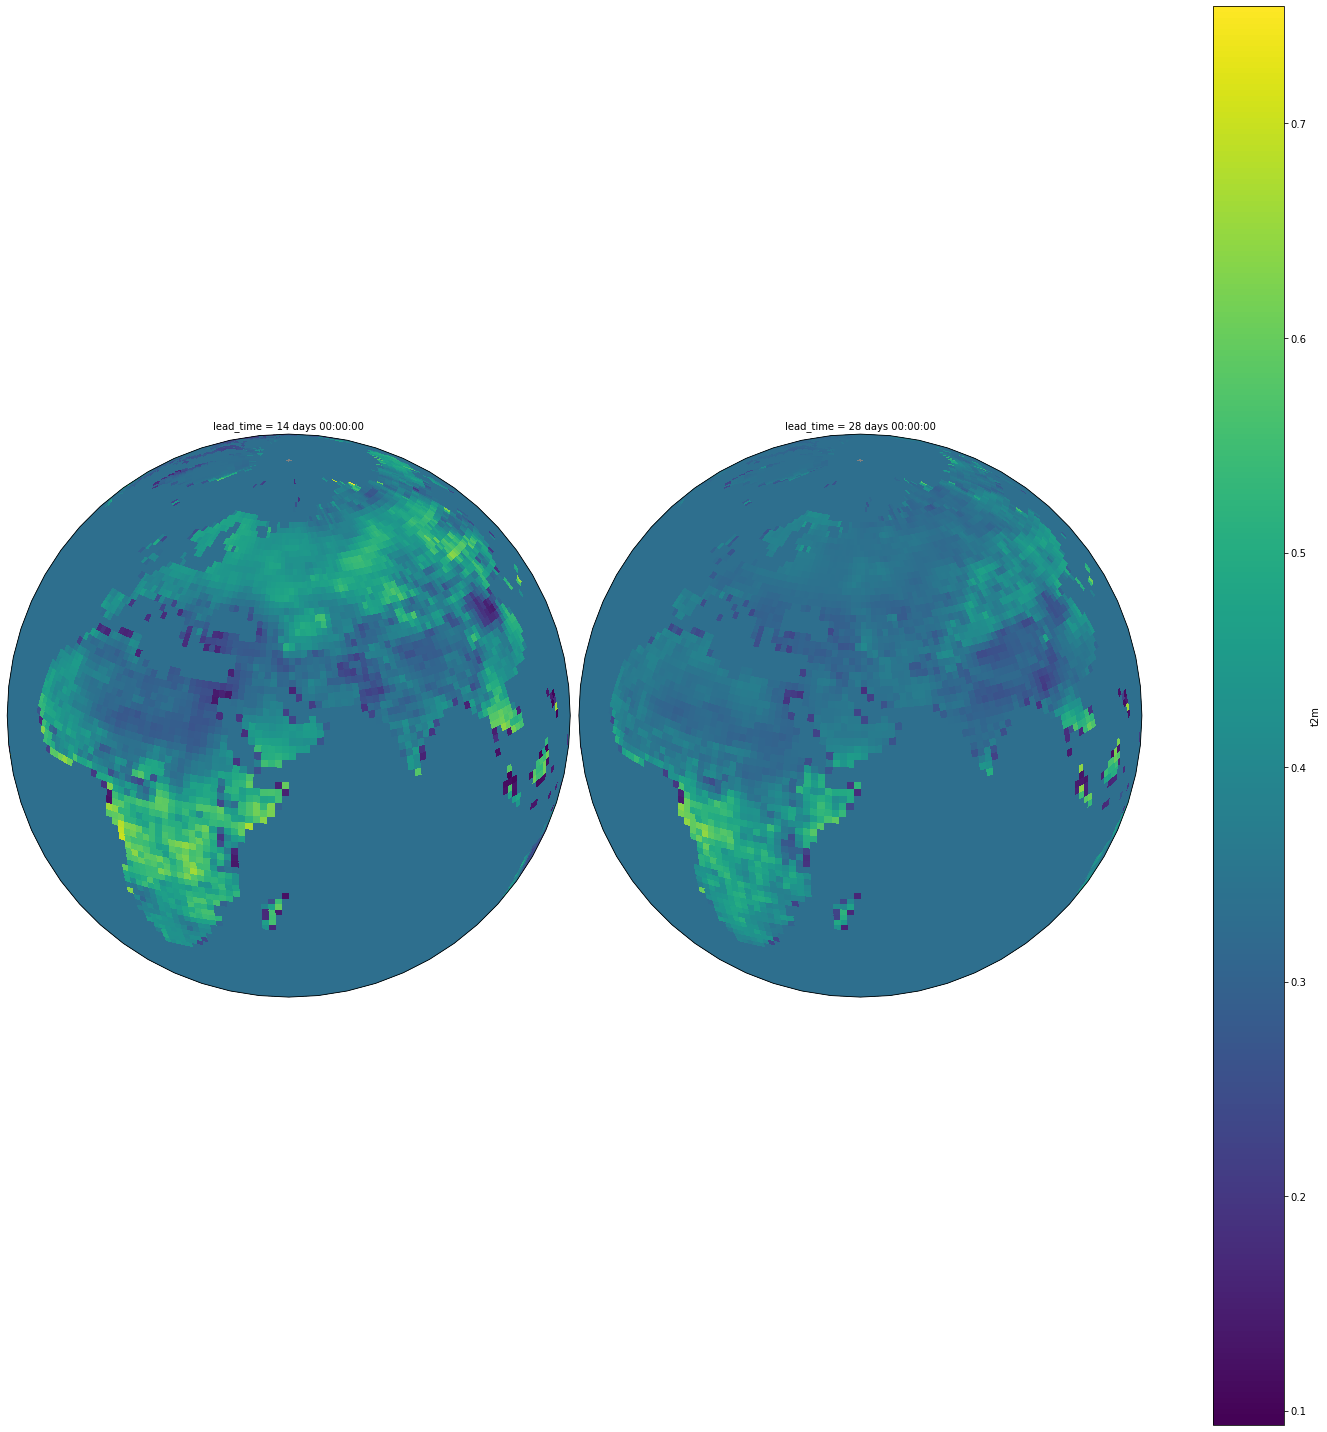

In [78]:
val.plot_by_region(what='predictions', region='Europe_Africa_Asia', orthographic=True)

Plot t2m for category n° 2 for predictions data for Oceania for forecast_time 0


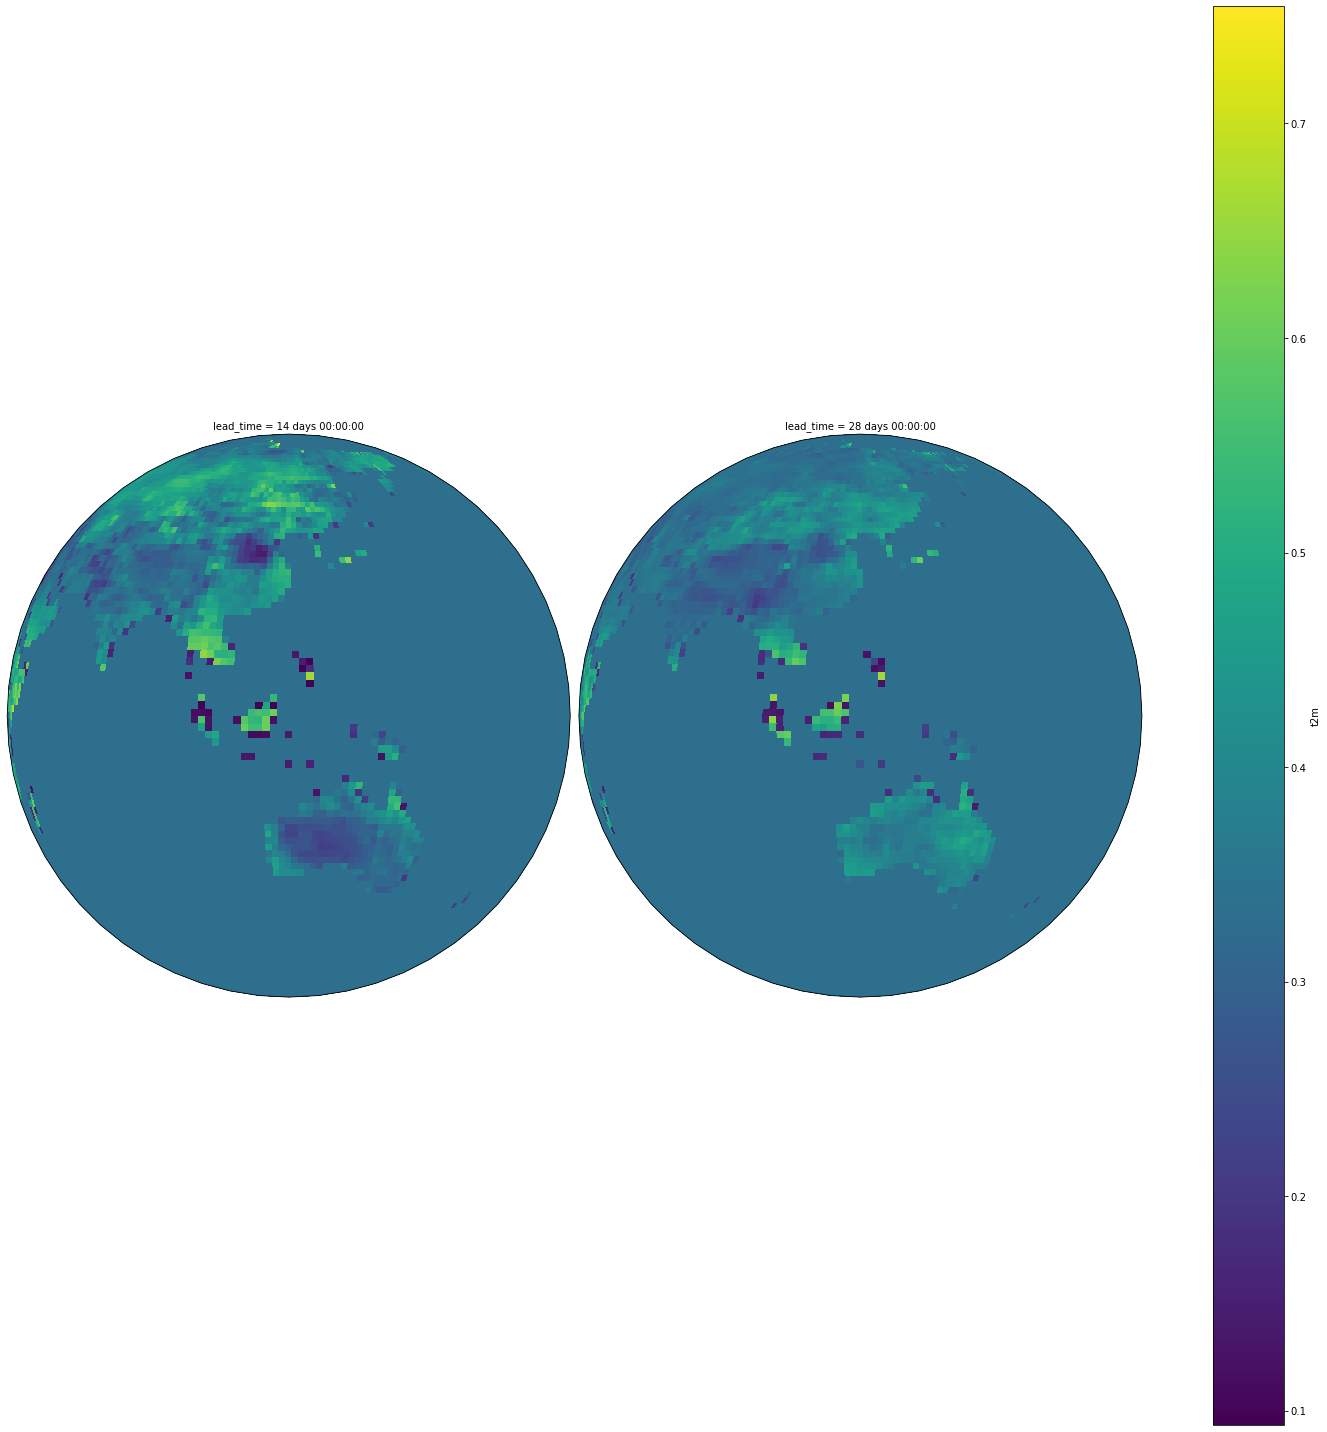

In [79]:
val.plot_by_region(what='predictions', region='Oceania', orthographic=True)

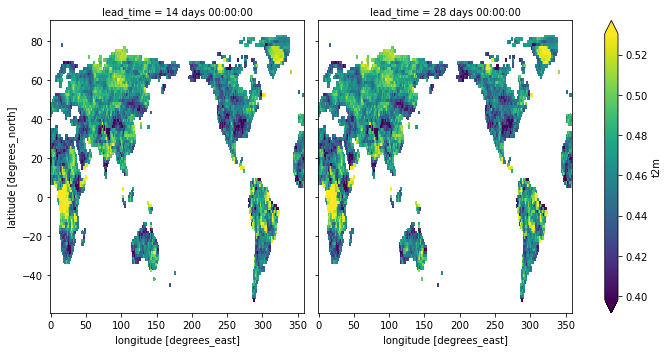

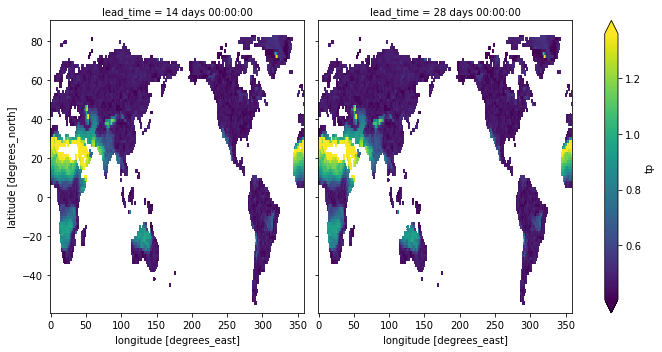

In [50]:
val.plot_rps()

In [51]:
val.compute_scores_from_scoring_image()

<xarray.Dataset>
Dimensions:        (lead_time: 2, forecast_time: 53, latitude: 121, longitude: 240)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (lead_time, forecast_time) datetime64[ns] ...
Data variables:
    t2m            (lead_time, forecast_time, latitude, longitude) float32 na...
    tp             (lead_time, forecast_time, latitude, longitude) float32 na...
<xarray.DataArray (variable: 2)>
array([0.01806534, 0.00371113])
Coordinates:
  * variable  (variable) <U3 't2m' 'tp'


0.010888232613658214

## Compute RPPS from organizers and Arlan's formula

In [52]:
organizers_rpss = val.compute_scores_from_organizers_RPSS(compute_each_tropics=COMPUTE_EACH_TROPICS)

In [53]:
arlan_rpss = val.compute_scores_from_arlan_RPSS(compute_each_tropics=COMPUTE_EACH_TROPICS)

In [54]:
rpss = pd.concat([organizers_rpss, arlan_rpss], axis=1, keys=['Organizer RPSS', 'Arlan RPSS'])
rpss.style.background_gradient(cmap=CMAP, vmin=-np.abs([rpss.min().min(), rpss.max().max()]).max(), vmax=np.abs([rpss.min().min(), rpss.max().max()]).max()).set_precision(2)

In [43]:
rpss = pd.concat([organizers_rpss, arlan_rpss], axis=1, keys=['Organizer RPSS', 'Arlan RPSS'])
rpss.style.background_gradient(cmap=CMAP, vmin=-np.abs([rpss.min().min(), rpss.max().max()]).max(), vmax=np.abs([rpss.min().min(), rpss.max().max()]).max()).set_precision(2)

## Compute and plot monthly scores

Here you can set keep_tropics to True to compute scores in function of tropics defined by organizers

In [55]:
scores_monthly = val.compute_monthly_scores(compute_each_tropics=COMPUTE_EACH_TROPICS)
scores_monthly.style.background_gradient(cmap=CMAP, vmin=-np.abs([rpss.min().min(), rpss.max().max()]).max(), vmax=np.abs([rpss.min().min(), rpss.max().max()]).max()).set_precision(2)

In [152]:
scores_monthly = val.compute_monthly_scores(compute_each_tropics=COMPUTE_EACH_TROPICS)
scores_monthly.style.background_gradient(cmap=CMAP, vmin=-np.abs([rpss.min().min(), rpss.max().max()]).max(), vmax=np.abs([rpss.min().min(), rpss.max().max()]).max()).set_precision(2)

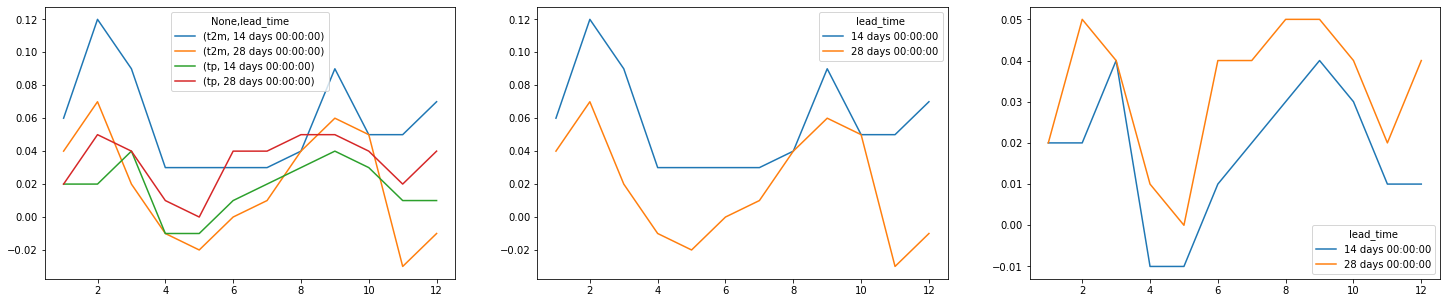

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
scores_monthly.transpose().plot(ax=axes[0])
scores_monthly.xs('t2m', axis=0).transpose().plot(ax=axes[1])
scores_monthly.xs('tp', axis=0).transpose().plot(ax=axes[2])

## Compute and plot trimestrial scores

In [56]:
scores_trimestrials = val.compute_trimestrial_scores()

In [57]:
scores_trimestrials.style.background_gradient(cmap=CMAP, vmin=-np.abs([rpss.min().min(), rpss.max().max()]).max(), vmax=np.abs([rpss.min().min(), rpss.max().max()]).max()).set_precision(2)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
scores_trimestrials.transpose().plot(ax=axes[0]) 
scores_trimestrials.xs('t2m', axis=0).transpose().plot(ax=axes[1])
scores_trimestrials.xs('tp', axis=0).transpose().plot(ax=axes[2])

## Export Notebook and figures

In [ ]:
EXPORT_DATA = False
if EXPORT_DATA:
    
    save_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S%f')[:-3]
    
    save_directory: str = os.path.join(EXPORT_PATH, save_date)
    os.mkdir(save_directory)
    
    writer = pd.ExcelWriter(os.path.join(save_directory, "scores.xlsx"), engine='xlsxwriter')
    scores_monthly.to_excel(writer, sheet_name='Monthly scores')
    scores_trimestrials.to_excel(writer, sheet_name='Trimestrial scores')
    organizers_rpss.to_excel(writer, sheet_name='Organizers RPSS')
    arlan_rpss.to_excel(writer, sheet_name='Arlan RPSS')
    writer.save()
    
    !jupyter nbconvert "JG - Validation.ipynb" --to html --output "Validation Notebook.html"